<a href="https://colab.research.google.com/github/pacasarini/spark/blob/main/Projeto_Final_Spark_for_Data_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Projeto final - Spark for Data Engineering - Profº Mathias Brem Garcia
#Faculdade Impacta - MBA Data Engineering.
#Alunos:
## Arthur Bassetti
## Alexandre Lucas Cavalcante Rocha
## Paula Cristina Casarini
## Luis Thiago Amorim de Moura

Proposta:
Título: Atividade Final - Análise de Dados com Spark e Grafos

Instruções: Nesta atividade final, os alunos serão divididos em grupos com um mínimo de 3 alunos e um máximo de 6 alunos por grupo. Cada grupo deverá completar um notebook do Jupyter, demonstrando uma execução livre de erros. O notebook deve incluir os seguintes passos:
* Importar conjuntos de dados públicos relevantes utilizando o módulo pyspark.sql.
* Criar uma ou mais tabelas utilizando a funcionalidade do SparkSQL, permitindo uma estrutura otimizada para consultas posteriores.
* Utilizar comandos SparkSQL para formatar os dados conforme necessário e realizar junções entre diferentes tabelas.
* Realizar uma análise de dados baseada em um grafo. Caso o grafo gerado seja extenso, aplicar técnicas de filtragem de grafo, similares aos exemplos discutidos em aula.

Os alunos devem abordar a atividade de forma colaborativa, aplicando seus conhecimentos sobre manipulação de dados, Spark e análise de grafos. O foco não está apenas na obtenção dos resultados corretos, mas também na organização, clareza e documentação do processo utilizado.
Os notebooks completos, juntamente com quaisquer conjuntos de dados externos utilizados, devem ser submetidos até a data estipulada. Certifiquem-se de que o código esteja bem comentado e explicado para facilitar a compreensão.
A avaliação considerará tanto os resultados obtidos quanto a qualidade da codificação, a profundidade da análise realizada e a capacidade de adaptação das técnicas aprendidas para lidar com desafios específicos dos conjuntos de dados utilizados.

## Configurando o ambiente Spark ##
Baixando, descompactando pacote do Apache Spark:

In [ ]:
!ls
!rm -rf *
#Instacao e configuracao do Java 8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Download do Apache Spark
!wget -q https://apache.osuosl.org/spark/spark-3.2.4/spark-3.2.4-bin-hadoop3.2.tgz
#Descompatacao do Apache Spark
!tar xf spark-3.2.4-bin-hadoop3.2.tgz
#Instalacao do Findspark
!pip install -q findspark

sample_data


Importando biblioteca "os" para setar variáveis do ambiente no sistema operacional:

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.4-bin-hadoop3.2"

Download da biblioteca graphframes-0.8.2-spark3.2-s_2.12.jar do Java para o Apache Spark:<br>
Fornece funcionalidade para criar e manipular dados de Grafo.

In [ ]:
!curl -L -o "/content/spark-3.2.4-bin-hadoop3.2/jars/graphframes-0.8.2-spark3.2-s_2.12.jar" https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  242k  100  242k    0     0  2671k      0 --:--:-- --:--:-- --:--:-- 2689k


Importando bibliotecas necessárias para o projeto:<br>
* SparkSession -> Para abrir uma sessao no Apache Spark
* pyspark.sql.functions -> Estamos importando algumas funções específicas para geração dos relatórios
* pyspark.sql.window -> Estamos importando o módulo "Window" para fazer uma classificacao por Ano.

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, avg, dense_rank, col, desc, split, min
from pyspark.sql.window import Window
spark = SparkSession.builder.master("local[*]").config("spark.jars.packages", "graphframes:graphframes:0.7.0-spark2.4-s_2.11").getOrCreate()

Mostrando a versão do Spark:

In [ ]:
import pyspark
print(pyspark.__version__)

3.2.4


# Baixando os dados
Instalando a Lib Kaggle para obter os dados para análise e manipulação

In [ ]:
!pip install kaggle

Setando variáveis de ambiente do Kaggle

In [ ]:
os.environ["KAGGLE_USERNAME"] = "paulacasarini"
os.environ["KAGGLE_KEY"] = "d1cf823697b918d67e9fad446e71daa0"

Baixando os datasets (são arquivos no formato CSV):

In [ ]:
!kaggle datasets download -d grouplens/movielens-20m-dataset

 97% 189M/195M [00:02<00:00, 107MB/s] 
100% 195M/195M [00:02<00:00, 87.1MB/s]


Descompactando o arquivo baixado:

In [ ]:
!unzip movielens-20m-dataset.zip


Archive:  movielens-20m-dataset.zip
  inflating: genome_scores.csv       
  inflating: genome_tags.csv         
  inflating: link.csv                
  inflating: movie.csv               
  inflating: rating.csv              
  inflating: tag.csv                 


Criando um Dataframe "df_movies":<br>
Esse CSV está estruturado, trazendo de forma correta as colunas. Por isso header=True e inferSchema=True

In [ ]:
path = "/content/movie.csv"
df_movies = spark.read.csv(path, header=True, inferSchema=True)


Exibindo o schema do Dataframe:<br>

In [ ]:
df_movies.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



Exibindo as 20 primeiras linhas do Dataframe:

In [ ]:
df_movies.show()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

Criando o Dataframe "rating" a partir do rating.csv:<br>
Neste dataframe ficam as notas de avaliações dos filmes e o ano em que receberam tais avaliações.

In [ ]:
path = "/content/rating.csv"
df_rating = spark.read.csv(path, header=True, inferSchema=True)

In [ ]:
df_rating.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: string (nullable = true)



In [ ]:
df_rating.show()

+------+-------+------+-------------------+
|userId|movieId|rating|          timestamp|
+------+-------+------+-------------------+
|     1|      2|   3.5|2005-04-02 23:53:47|
|     1|     29|   3.5|2005-04-02 23:31:16|
|     1|     32|   3.5|2005-04-02 23:33:39|
|     1|     47|   3.5|2005-04-02 23:32:07|
|     1|     50|   3.5|2005-04-02 23:29:40|
|     1|    112|   3.5|2004-09-10 03:09:00|
|     1|    151|   4.0|2004-09-10 03:08:54|
|     1|    223|   4.0|2005-04-02 23:46:13|
|     1|    253|   4.0|2005-04-02 23:35:40|
|     1|    260|   4.0|2005-04-02 23:33:46|
|     1|    293|   4.0|2005-04-02 23:31:43|
|     1|    296|   4.0|2005-04-02 23:32:47|
|     1|    318|   4.0|2005-04-02 23:33:18|
|     1|    337|   3.5|2004-09-10 03:08:29|
|     1|    367|   3.5|2005-04-02 23:53:00|
|     1|    541|   4.0|2005-04-02 23:30:03|
|     1|    589|   3.5|2005-04-02 23:45:57|
|     1|    593|   3.5|2005-04-02 23:31:01|
|     1|    653|   3.0|2004-09-10 03:08:11|
|     1|    919|   3.5|2004-09-1

Como os dataframes df_rating e df_movies possuem a coluna "movieId" com o mesmo nome, vamos renomea-la no dataframe "df_movies":

In [ ]:
df_movies = df_movies.withColumnRenamed("movieId", "Id")

Executando Inner Join nos dataframes df_rating e df_movies:<br>
O "Inner join" é padrão no "join" no PySpark, ele irá retornar somente os campos que existem na dois dataframes.<br>
Estamos utilizando a função "select" para trazer somente campos que nos interessam e não duplicar informações.<br>
Esse join está trazendo informações dos dois dataframe onde o campo "Id" do dataframe df_movies tem que ser igual ao "moveid" do dataframe df_rating.

In [ ]:
df_join = df_movies.join(df_rating,df_movies.Id ==  df_rating.movieId,"inner").select("Id", "title", "genres","userId", "rating", "timestamp")

In [ ]:
df_join.show()

+---+--------------------+--------------------+------+------+-------------------+
| Id|               title|              genres|userId|rating|          timestamp|
+---+--------------------+--------------------+------+------+-------------------+
|  2|      Jumanji (1995)|Adventure|Childre...|     1|   3.5|2005-04-02 23:53:47|
| 29|City of Lost Chil...|Adventure|Drama|F...|     1|   3.5|2005-04-02 23:31:16|
| 32|Twelve Monkeys (a...|Mystery|Sci-Fi|Th...|     1|   3.5|2005-04-02 23:33:39|
| 47|Seven (a.k.a. Se7...|    Mystery|Thriller|     1|   3.5|2005-04-02 23:32:07|
| 50|Usual Suspects, T...|Crime|Mystery|Thr...|     1|   3.5|2005-04-02 23:29:40|
|112|Rumble in the Bro...|Action|Adventure|...|     1|   3.5|2004-09-10 03:09:00|
|151|      Rob Roy (1995)|Action|Drama|Roma...|     1|   4.0|2004-09-10 03:08:54|
|223|       Clerks (1994)|              Comedy|     1|   4.0|2005-04-02 23:46:13|
|253|Interview with th...|        Drama|Horror|     1|   4.0|2005-04-02 23:35:40|
|260|Star Wars: 

Criando uma nova coluna no Dataframe df_Join:<br>
Estamos criando uma nova Coluna Chamada "Year" para fazermos o groupBy por Ano.

In [ ]:
df_join = df_join.withColumn("year", year("timestamp"))

In [ ]:
df_join.show()

+---+--------------------+--------------------+------+------+-------------------+----+
| Id|               title|              genres|userId|rating|          timestamp|year|
+---+--------------------+--------------------+------+------+-------------------+----+
|  2|      Jumanji (1995)|Adventure|Childre...|     1|   3.5|2005-04-02 23:53:47|2005|
| 29|City of Lost Chil...|Adventure|Drama|F...|     1|   3.5|2005-04-02 23:31:16|2005|
| 32|Twelve Monkeys (a...|Mystery|Sci-Fi|Th...|     1|   3.5|2005-04-02 23:33:39|2005|
| 47|Seven (a.k.a. Se7...|    Mystery|Thriller|     1|   3.5|2005-04-02 23:32:07|2005|
| 50|Usual Suspects, T...|Crime|Mystery|Thr...|     1|   3.5|2005-04-02 23:29:40|2005|
|112|Rumble in the Bro...|Action|Adventure|...|     1|   3.5|2004-09-10 03:09:00|2004|
|151|      Rob Roy (1995)|Action|Drama|Roma...|     1|   4.0|2004-09-10 03:08:54|2004|
|223|       Clerks (1994)|              Comedy|     1|   4.0|2005-04-02 23:46:13|2005|
|253|Interview with th...|        Drama|Hor

Contando Quantidade distinta de Gêneros dos filmes

In [ ]:
df_join.selectExpr("count(distinct genres) as QuantidadeGeneros").show()

+-----------------+
|QuantidadeGeneros|
+-----------------+
|             1329|
+-----------------+



Fazendo Split do campo "genre":<br>
Pegando a primeira Palavra antes do "|" no campo "genres" com a função "split" e gerando uma nova coluna chamada "first_genre" para receber esses novos dados.

In [ ]:
df_join = df_join.withColumn("first_genre", split(df_join["genres"], "\\|")[0])

In [ ]:
df_join.show()

+---+--------------------+--------------------+------+------+-------------------+----+-----------+
| Id|               title|              genres|userId|rating|          timestamp|year|first_genre|
+---+--------------------+--------------------+------+------+-------------------+----+-----------+
|  2|      Jumanji (1995)|Adventure|Childre...|     1|   3.5|2005-04-02 23:53:47|2005|  Adventure|
| 29|City of Lost Chil...|Adventure|Drama|F...|     1|   3.5|2005-04-02 23:31:16|2005|  Adventure|
| 32|Twelve Monkeys (a...|Mystery|Sci-Fi|Th...|     1|   3.5|2005-04-02 23:33:39|2005|    Mystery|
| 47|Seven (a.k.a. Se7...|    Mystery|Thriller|     1|   3.5|2005-04-02 23:32:07|2005|    Mystery|
| 50|Usual Suspects, T...|Crime|Mystery|Thr...|     1|   3.5|2005-04-02 23:29:40|2005|      Crime|
|112|Rumble in the Bro...|Action|Adventure|...|     1|   3.5|2004-09-10 03:09:00|2004|     Action|
|151|      Rob Roy (1995)|Action|Drama|Roma...|     1|   4.0|2004-09-10 03:08:54|2004|     Action|
|223|     

Vamos gerar uma lista de Generos só para validar a quantidade:<br>
Utilizamos a função "distinct" para não trazer valores duplicados, afinal foram encontrados mais de 20 milhões de registros.

In [ ]:
generos = df_join.select("genres").distinct()

Gerando uma Lista:

In [ ]:
generosLista = generos.select("genres").rdd.flatMap(lambda x: x).collect()

In [ ]:
print(type(generosLista)) #Mostrando tipo da varivel
print(len(generosLista)) #Contando quantidade de registros

<class 'list'>
1329


Contando Generos diferentes a partir de uma lista (para futura comparação e validação no próximo passo):

In [ ]:
GenerosUnicos = []
for x in generosLista:
  for y in x.split('|'):
    if y != '':
      GenerosUnicos.append(y)

In [ ]:
GenerosUnicos = set(GenerosUnicos)
print(len(GenerosUnicos))

20


Contando novamente quantidade de Generos, agora pela coluna "first_genre":

In [ ]:
df_join.selectExpr("count(distinct first_genre) as QuantidadeGeneros").show()

+-----------------+
|QuantidadeGeneros|
+-----------------+
|               20|
+-----------------+



In [ ]:
df_join.show()

+---+--------------------+--------------------+------+------+-------------------+----+-----------+
| Id|               title|              genres|userId|rating|          timestamp|year|first_genre|
+---+--------------------+--------------------+------+------+-------------------+----+-----------+
|  2|      Jumanji (1995)|Adventure|Childre...|     1|   3.5|2005-04-02 23:53:47|2005|  Adventure|
| 29|City of Lost Chil...|Adventure|Drama|F...|     1|   3.5|2005-04-02 23:31:16|2005|  Adventure|
| 32|Twelve Monkeys (a...|Mystery|Sci-Fi|Th...|     1|   3.5|2005-04-02 23:33:39|2005|    Mystery|
| 47|Seven (a.k.a. Se7...|    Mystery|Thriller|     1|   3.5|2005-04-02 23:32:07|2005|    Mystery|
| 50|Usual Suspects, T...|Crime|Mystery|Thr...|     1|   3.5|2005-04-02 23:29:40|2005|      Crime|
|112|Rumble in the Bro...|Action|Adventure|...|     1|   3.5|2004-09-10 03:09:00|2004|     Action|
|151|      Rob Roy (1995)|Action|Drama|Roma...|     1|   4.0|2004-09-10 03:08:54|2004|     Action|
|223|     

Agrupando dados:<br>
Estamos fazendo o groupBy por Ano Titulo e Genero.<br>
A função 'min()' foi utilizada na coluna "year" para trazer apenas o ano de lançamento do filme.<br>
A função 'avg()' foi utilizada para fazer uma média do campo "rating".<br>
As duas colunas foram renomeadas.

In [ ]:
df_agrupado = df_join.groupBy("Id", "title", "first_genre").agg(avg("rating").alias("avg_rating"), min("year").alias("min_year"))

In [ ]:
df_agrupado.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- first_genre: string (nullable = true)
 |-- avg_rating: double (nullable = true)
 |-- min_year: integer (nullable = true)



In [ ]:
df_agrupado.show(10)

+-----+--------------------+-----------+------------------+--------+
|   Id|               title|first_genre|        avg_rating|min_year|
+-----+--------------------+-----------+------------------+--------+
| 4941| Flash Gordon (1980)|     Action|3.0682766845557543|    2001|
| 8961|Incredibles, The ...|     Action| 3.908572146807441|    2004|
|  852|      Tin Cup (1996)|     Comedy| 3.188299990518631|    1996|
| 4299|Knight's Tale, A ...|     Action| 3.243097884546432|    2001|
| 8870|Forgotten, The (2...|      Drama|2.8939519469759736|    2004|
|52885|Paprika (Papurika...|  Animation|3.8625192012288787|    2007|
|  468|Englishman Who We...|     Comedy|3.3182931808901595|    1996|
|  745|Wallace & Gromit:...|  Animation| 4.167315497390872|    1996|
|  191|Scarlet Letter, T...|      Drama| 2.676081730769231|    1996|
| 4734|Jay and Silent Bo...|  Adventure| 3.292894140498543|    2001|
+-----+--------------------+-----------+------------------+--------+
only showing top 10 rows



Criando um tabela temporaria para executar "select":

In [ ]:
df_agrupado.createOrReplaceTempView("DFAgrupado")

Validando se está trazendo apenas o registro mais antigo:

In [ ]:
spark.sql("SELECT * from DFAgrupado where title = 'WALL·E (2008)'").show()

+-----+-------------+-----------+-----------------+--------+
|   Id|        title|first_genre|       avg_rating|min_year|
+-----+-------------+-----------+-----------------+--------+
|60069|WALL·E (2008)|  Adventure|4.038929040735874|    2008|
+-----+-------------+-----------+-----------------+--------+



Utilizando a função "dense_rank" para classificarmos quais filmes tiveram a maior média.<br>
A função "Window.partionBy", irá dividir os dados em grupos por Ano.

In [ ]:
df_rank = df_agrupado.withColumn("rank", dense_rank().over(Window.partitionBy("min_year").orderBy(desc("avg_rating"))))

In [ ]:
df_rank.show()

+----+--------------------+-----------+------------------+--------+----+
|  Id|               title|first_genre|        avg_rating|min_year|rank|
+----+--------------------+-----------+------------------+--------+----+
|  47|Seven (a.k.a. Se7...|    Mystery| 4.053492566302111|    1995|   1|
|1176|Double Life of Ve...|      Drama| 3.890561667631731|    1995|   2|
|1079|Fish Called Wanda...|     Comedy| 3.849623869065772|    1995|   3|
|  21|   Get Shorty (1995)|     Comedy| 3.581688505556477|    1995|   4|
| 318|Shawshank Redempt...|      Crime| 4.446990499637029|    1996|   1|
| 858|Godfather, The (1...|      Crime| 4.364732196832306|    1996|   2|
|  50|Usual Suspects, T...|      Crime| 4.334372207803259|    1996|   3|
| 527|Schindler's List ...|      Drama| 4.310175010988133|    1996|   4|
|1221|Godfather: Part I...|      Crime| 4.275640557704942|    1996|   5|
|2019|Seven Samurai (Sh...|     Action|   4.2741796572216|    1996|   6|
| 904|  Rear Window (1954)|    Mystery| 4.271333600

Criando uma View para executar Queries:

In [ ]:
df_rank.createOrReplaceTempView("TopFilmes")

Executamos uma query na View "TopFilmes" para listar filmes que o "rank" é igual 1 e o genero "Comedy":

In [ ]:
spark.sql("SELECT min_year, title, first_genre, avg_rating, rank from TopFilmes where rank = 1 and first_genre = 'Comedy' order by min_year").show()

+--------+--------------------+-----------+-----------------+----+
|min_year|               title|first_genre|       avg_rating|rank|
+--------+--------------------+-----------+-----------------+----+
|    1998|Life Is Beautiful...|     Comedy|4.175837188808107|   1|
|    2001|Amelie (Fabuleux ...|     Comedy| 4.19707174832642|   1|
|    2004|    Love Life (2001)|     Comedy|4.333333333333333|   1|
|    2008|Supermarket Woman...|     Comedy|             4.75|   1|
|    2011|Out 1: Spectre (1...|     Comedy|             4.75|   1|
|    2012|Prom Queen: The M...|     Comedy|              5.0|   1|
|    2013|Flight of the Con...|     Comedy|              5.0|   1|
|    2013|Diplomatic Immuni...|     Comedy|              5.0|   1|
|    2013|       B-Side (2013)|     Comedy|              5.0|   1|
|    2014|The great match (...|     Comedy|              5.0|   1|
|    2014|Foster Brothers, ...|     Comedy|              5.0|   1|
|    2014|Doggiewoggiez! Po...|     Comedy|              5.0| 

# GRÁFICOS/GRAFOS

Vamos trabalhar com o Dataframe df_grafo, cópia do df_agrupado:<br>

In [ ]:
df_grafo = df_agrupado

In [ ]:
df_grafo.show()

+------+--------------------+-----------+------------------+--------+
|    Id|               title|first_genre|        avg_rating|min_year|
+------+--------------------+-----------+------------------+--------+
|  4941| Flash Gordon (1980)|     Action|3.0682766845557543|    2001|
|  8961|Incredibles, The ...|     Action| 3.908572146807441|    2004|
|   852|      Tin Cup (1996)|     Comedy| 3.188299990518631|    1996|
|  4299|Knight's Tale, A ...|     Action| 3.243097884546432|    2001|
|  8870|Forgotten, The (2...|      Drama|2.8939519469759736|    2004|
| 52885|Paprika (Papurika...|  Animation|3.8625192012288787|    2007|
|   468|Englishman Who We...|     Comedy|3.3182931808901595|    1996|
|   745|Wallace & Gromit:...|  Animation| 4.167315497390872|    1996|
|   191|Scarlet Letter, T...|      Drama| 2.676081730769231|    1996|
|  4734|Jay and Silent Bo...|  Adventure| 3.292894140498543|    2001|
|  8983|House of Flying D...|     Action|3.7448409808205874|    2004|
|   472|I'll Do Anyt

Importando bibliotecas necessárias para geração do gráfico:<br>

In [ ]:
from graphframes import GraphFrame
from pyspark.sql.functions import row_number, col
import networkx as nx
import matplotlib.pyplot as plt

Agrupando por genero e contando quantidade de filmes:

In [ ]:
contagem_por_genero = df_grafo.groupBy("first_genre").count().orderBy("count", ascending=False)

Convertendo para o Pandas para gerar o gráfico de barras:

In [ ]:
contagem_por_genero_df = contagem_por_genero.toPandas()

Gáfico de barras:

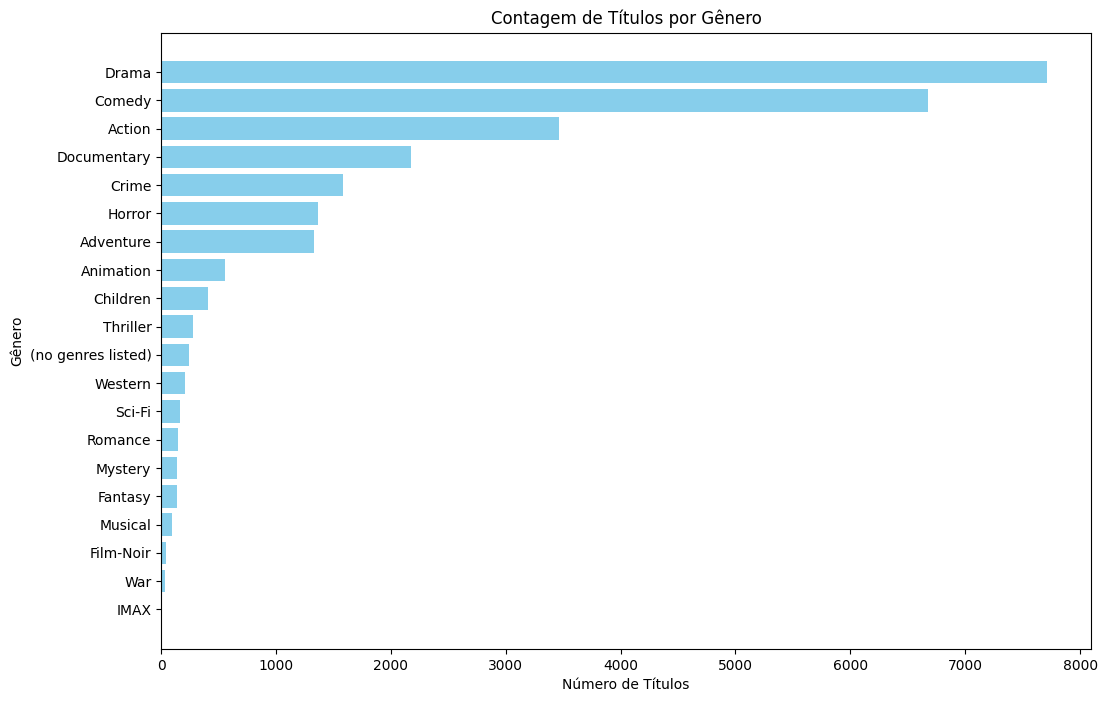

In [ ]:
plt.figure(figsize=(12, 8))
plt.barh(contagem_por_genero_df["first_genre"], contagem_por_genero_df["count"], color="skyblue")
plt.xlabel("Número de Títulos")
plt.ylabel("Gênero")
plt.title("Contagem de Títulos por Gênero")
plt.gca().invert_yaxis()
plt.show()

# Grafico de Relacionamento

Montagem de um gráfico relacionando os filmes por tipo de genero:<br>
Como são muitos registros, tivemos que filtrar para ter uma boa visualização do gráfico.<br>
Escolhemos mostrar os 50 filmes melhores rankeados na categoria "Action".

In [ ]:
filtered_df = df_grafo.filter(df_grafo.first_genre == "Action")
window_spec = Window.partitionBy("first_genre").orderBy(col("avg_rating").desc())
ranked_df = filtered_df.withColumn("rank", row_number().over(window_spec))
filtered_df = ranked_df.filter(col("rank") <= 50)

In [ ]:
filtered_df.show()

+------+--------------------+-----------+-----------------+--------+----+
|    Id|               title|first_genre|       avg_rating|min_year|rank|
+------+--------------------+-----------+-----------------+--------+----+
| 98761|Shaolin Temple 2:...|     Action|              5.0|    2013|   1|
|117506|      Deewaar (1975)|     Action|4.666666666666667|    2014|   2|
|130219|The Dark Knight (...|     Action|              4.5|    2015|   3|
|108466|Curse of the Ring...|     Action|              4.5|    2014|   4|
|102219|Perils of the Sen...|     Action|              4.5|    2013|   5|
|102340|Sentimental Sword...|     Action|              4.5|    2013|   6|
|105439|Sword of Desperat...|     Action|              4.5|    2013|   7|
|115998|The Guardians (2012)|     Action|              4.5|    2014|   8|
|116285|   Crazy Mama (1975)|     Action|              4.5|    2015|   9|
|111329| Memorial Day (2011)|     Action|              4.5|    2014|  10|
|112907|Villain, The (Ek ...|     Acti

Criando dataframes com Vértices e Arestas

In [ ]:
vertices = filtered_df.selectExpr("title as id").union(filtered_df.selectExpr("first_genre as id")).distinct() #Cria um DataFrame com vértices (títulos e gêneros)
edges = filtered_df.selectExpr("title as src", "first_genre as dst") #Cria um DataFrame com arestas (relacionamento entre títulos e gêneros)
g = GraphFrame(vertices, edges)

Mostrando o dataframe com vértices:

In [ ]:
g.vertices.show()

+--------------------+
|                  id|
+--------------------+
|North by Northwes...|
|Once Upon a Time ...|
|Raiders of the Lo...|
|Lord of the Rings...|
|   Harmagedon (1986)|
|Dark Knight, The ...|
|   Crazy Mama (1975)|
|Mahabharata, The ...|
|Man on High Heels...|
|      Henry V (1989)|
|Princess Bride, T...|
|Great Escape, The...|
|      Deewaar (1975)|
|The Great Spy Cha...|
|The Dark Knight (...|
|Fighter in the Wi...|
|      Ikigami (2008)|
|Meltdown (Shu dan...|
|The Magnificent G...|
| Memorial Day (2011)|
+--------------------+
only showing top 20 rows



Mostrando o dataframe com arestas:

In [ ]:
g.edges.show()

+--------------------+------+
|                 src|   dst|
+--------------------+------+
|Shaolin Temple 2:...|Action|
|      Deewaar (1975)|Action|
|The Dark Knight (...|Action|
|Curse of the Ring...|Action|
|Perils of the Sen...|Action|
|Sentimental Sword...|Action|
|Sword of Desperat...|Action|
|The Guardians (2012)|Action|
|   Crazy Mama (1975)|Action|
| Memorial Day (2011)|Action|
|Villain, The (Ek ...|Action|
|      Ikigami (2008)|Action|
|Meltdown (Shu dan...|Action|
|Boogie (Boogie, e...|Action|
|The Magnificent G...|Action|
|       Monday (2000)|Action|
|Deathstalker II (...|Action|
|18 Fingers of Dea...|Action|
|The Great Spy Cha...|Action|
|Two Rabbits (2 Co...|Action|
+--------------------+------+
only showing top 20 rows



Função para geração do gráfico utilizando o graphFrames:

In [ ]:
def plot_graph(es):
    g = nx.DiGraph()
    for row in es.select('src','dst').collect():
        g.add_edge(row['src'],row['dst'])

    nx.draw(g, with_labels=True, node_color='yellow')

Exibindo Gráfico:
O GraphFrame não lida com a renderização ou ajuste do tamanho de imagens de grafos.<br>
Constatado isso, aprimoraremos o gráfico com as bibliotecas 'networkx' e 'matplotlib'.

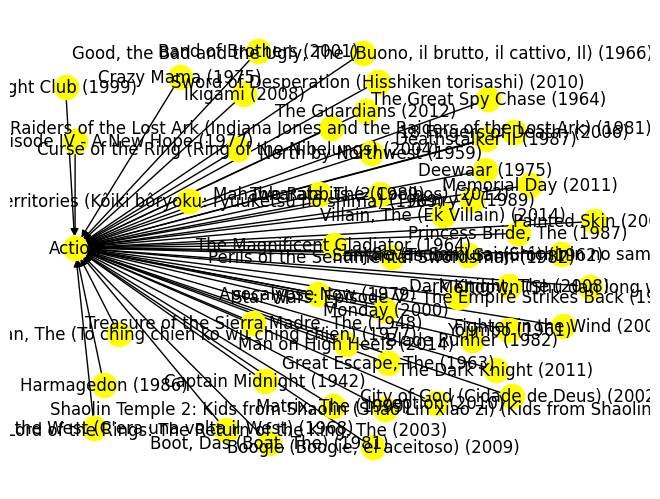

In [ ]:
plot_graph(g.edges)

Criando um novo gráfico com o 'networkx':

In [ ]:
G = nx.DiGraph()
#Adicionar nós (títulos e gêneros) ao grafo
for row in vertices.collect():
    G.add_node(row['id'])
#Adicionar arestas ao grafo
for row in edges.collect():
    G.add_edge(row['src'], row['dst'])

Gráfico:

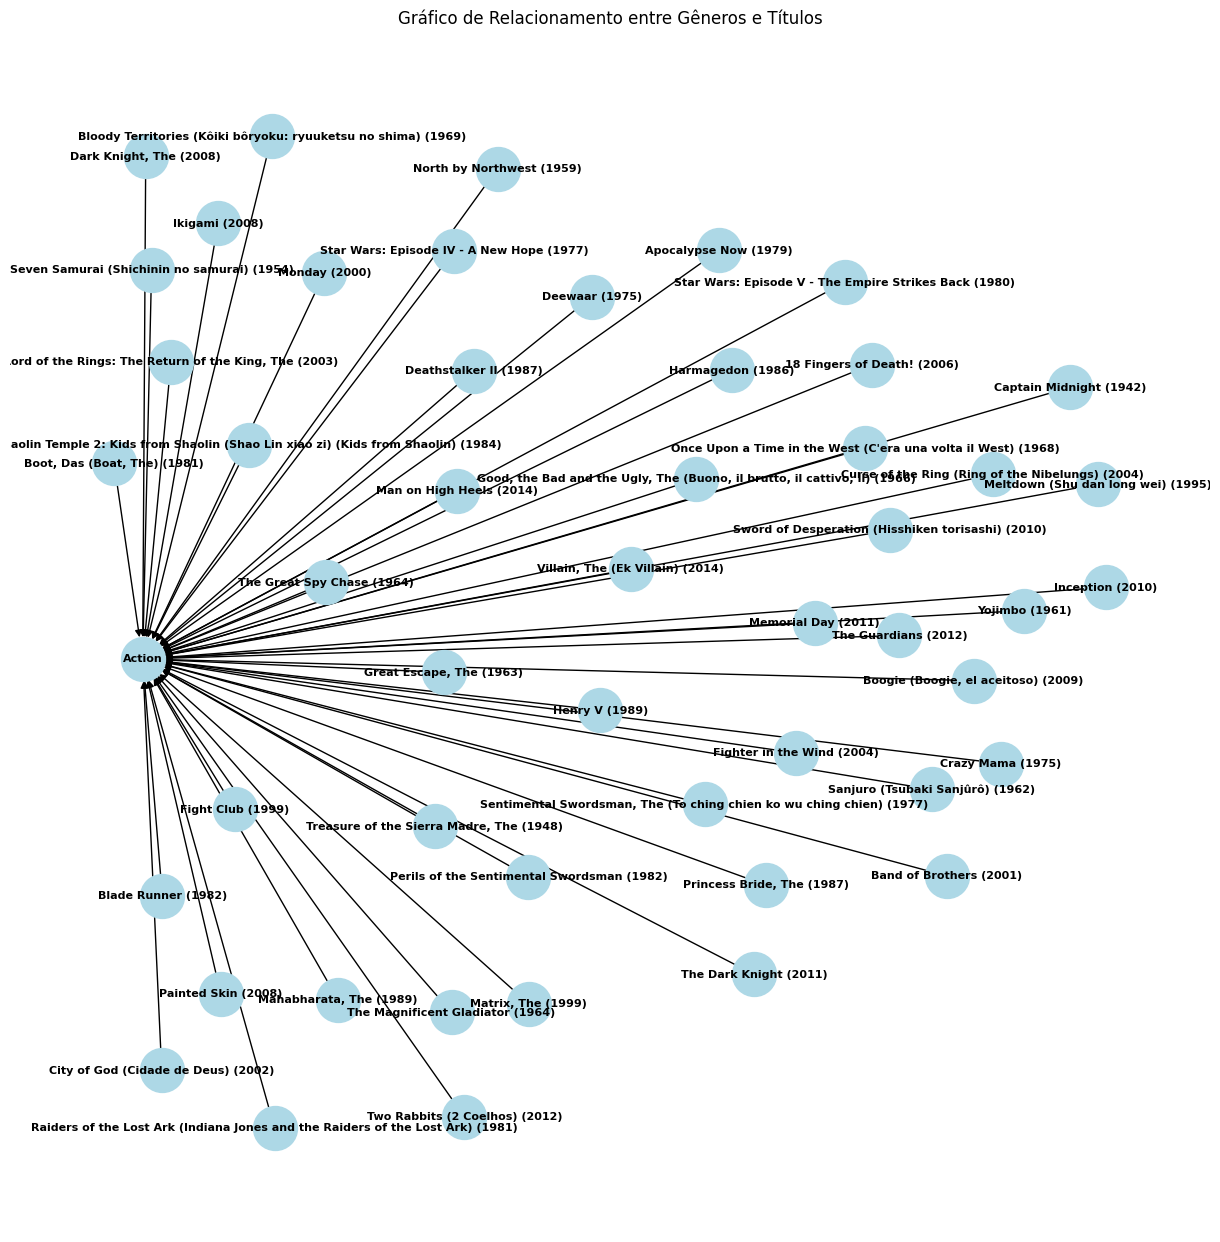

In [ ]:
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='lightblue', font_size=8, font_weight='bold')
plt.title('Gráfico de Relacionamento entre Gêneros e Títulos')
plt.show()

Abaixo estamos gerando um gráfico fazendo um relacionamento dos gêneros dos filmes.<br>
Os filmes possuem mais de um gênero.<br>
Importamos a biblioteca 'random', para adicionar cores aleatoriamente aos nomes dos filmes (title).

In [ ]:
import random

df_moviesNovo = df_movies.toPandas()
filmes_selecionados = df_moviesNovo['title'][:120] # Mostra 120 primeiros filmes do dataframe
G = nx.DiGraph() #Criando um grafo vazio para adicionar nodes e edges
node_colors = {} #Cria um dicionario vazio para receber as cores dos Titles (filmes)

#Adicionando nós para todos os gêneros distintos
generos_distintos = set()
for _, row in df_moviesNovo.iterrows():
    generos = row['genres'].split('|')
    generos_distintos.update(generos)
for genero in generos_distintos:
    G.add_node(genero, tipo='Genero')

# Adiciona nós para os títulos selecionados e cria conexões para os gêneros que eles contêm
for titulo in filmes_selecionados:
    generos = df_moviesNovo[df_moviesNovo['title'] == titulo]['genres'].values[0].split('|')
    G.add_node(titulo, tipo='Filme')
    #Atribuir cores aleatórias apenas aos nós de Filme
    node_color = plt.cm.rainbow(random.random())
    node_colors[titulo] = node_color
    for genero in generos:
        G.add_edge(titulo, genero)

Nessa etapa estamos setando configurações do gráfico, como: tamanho, cores e dimensões dos nós:

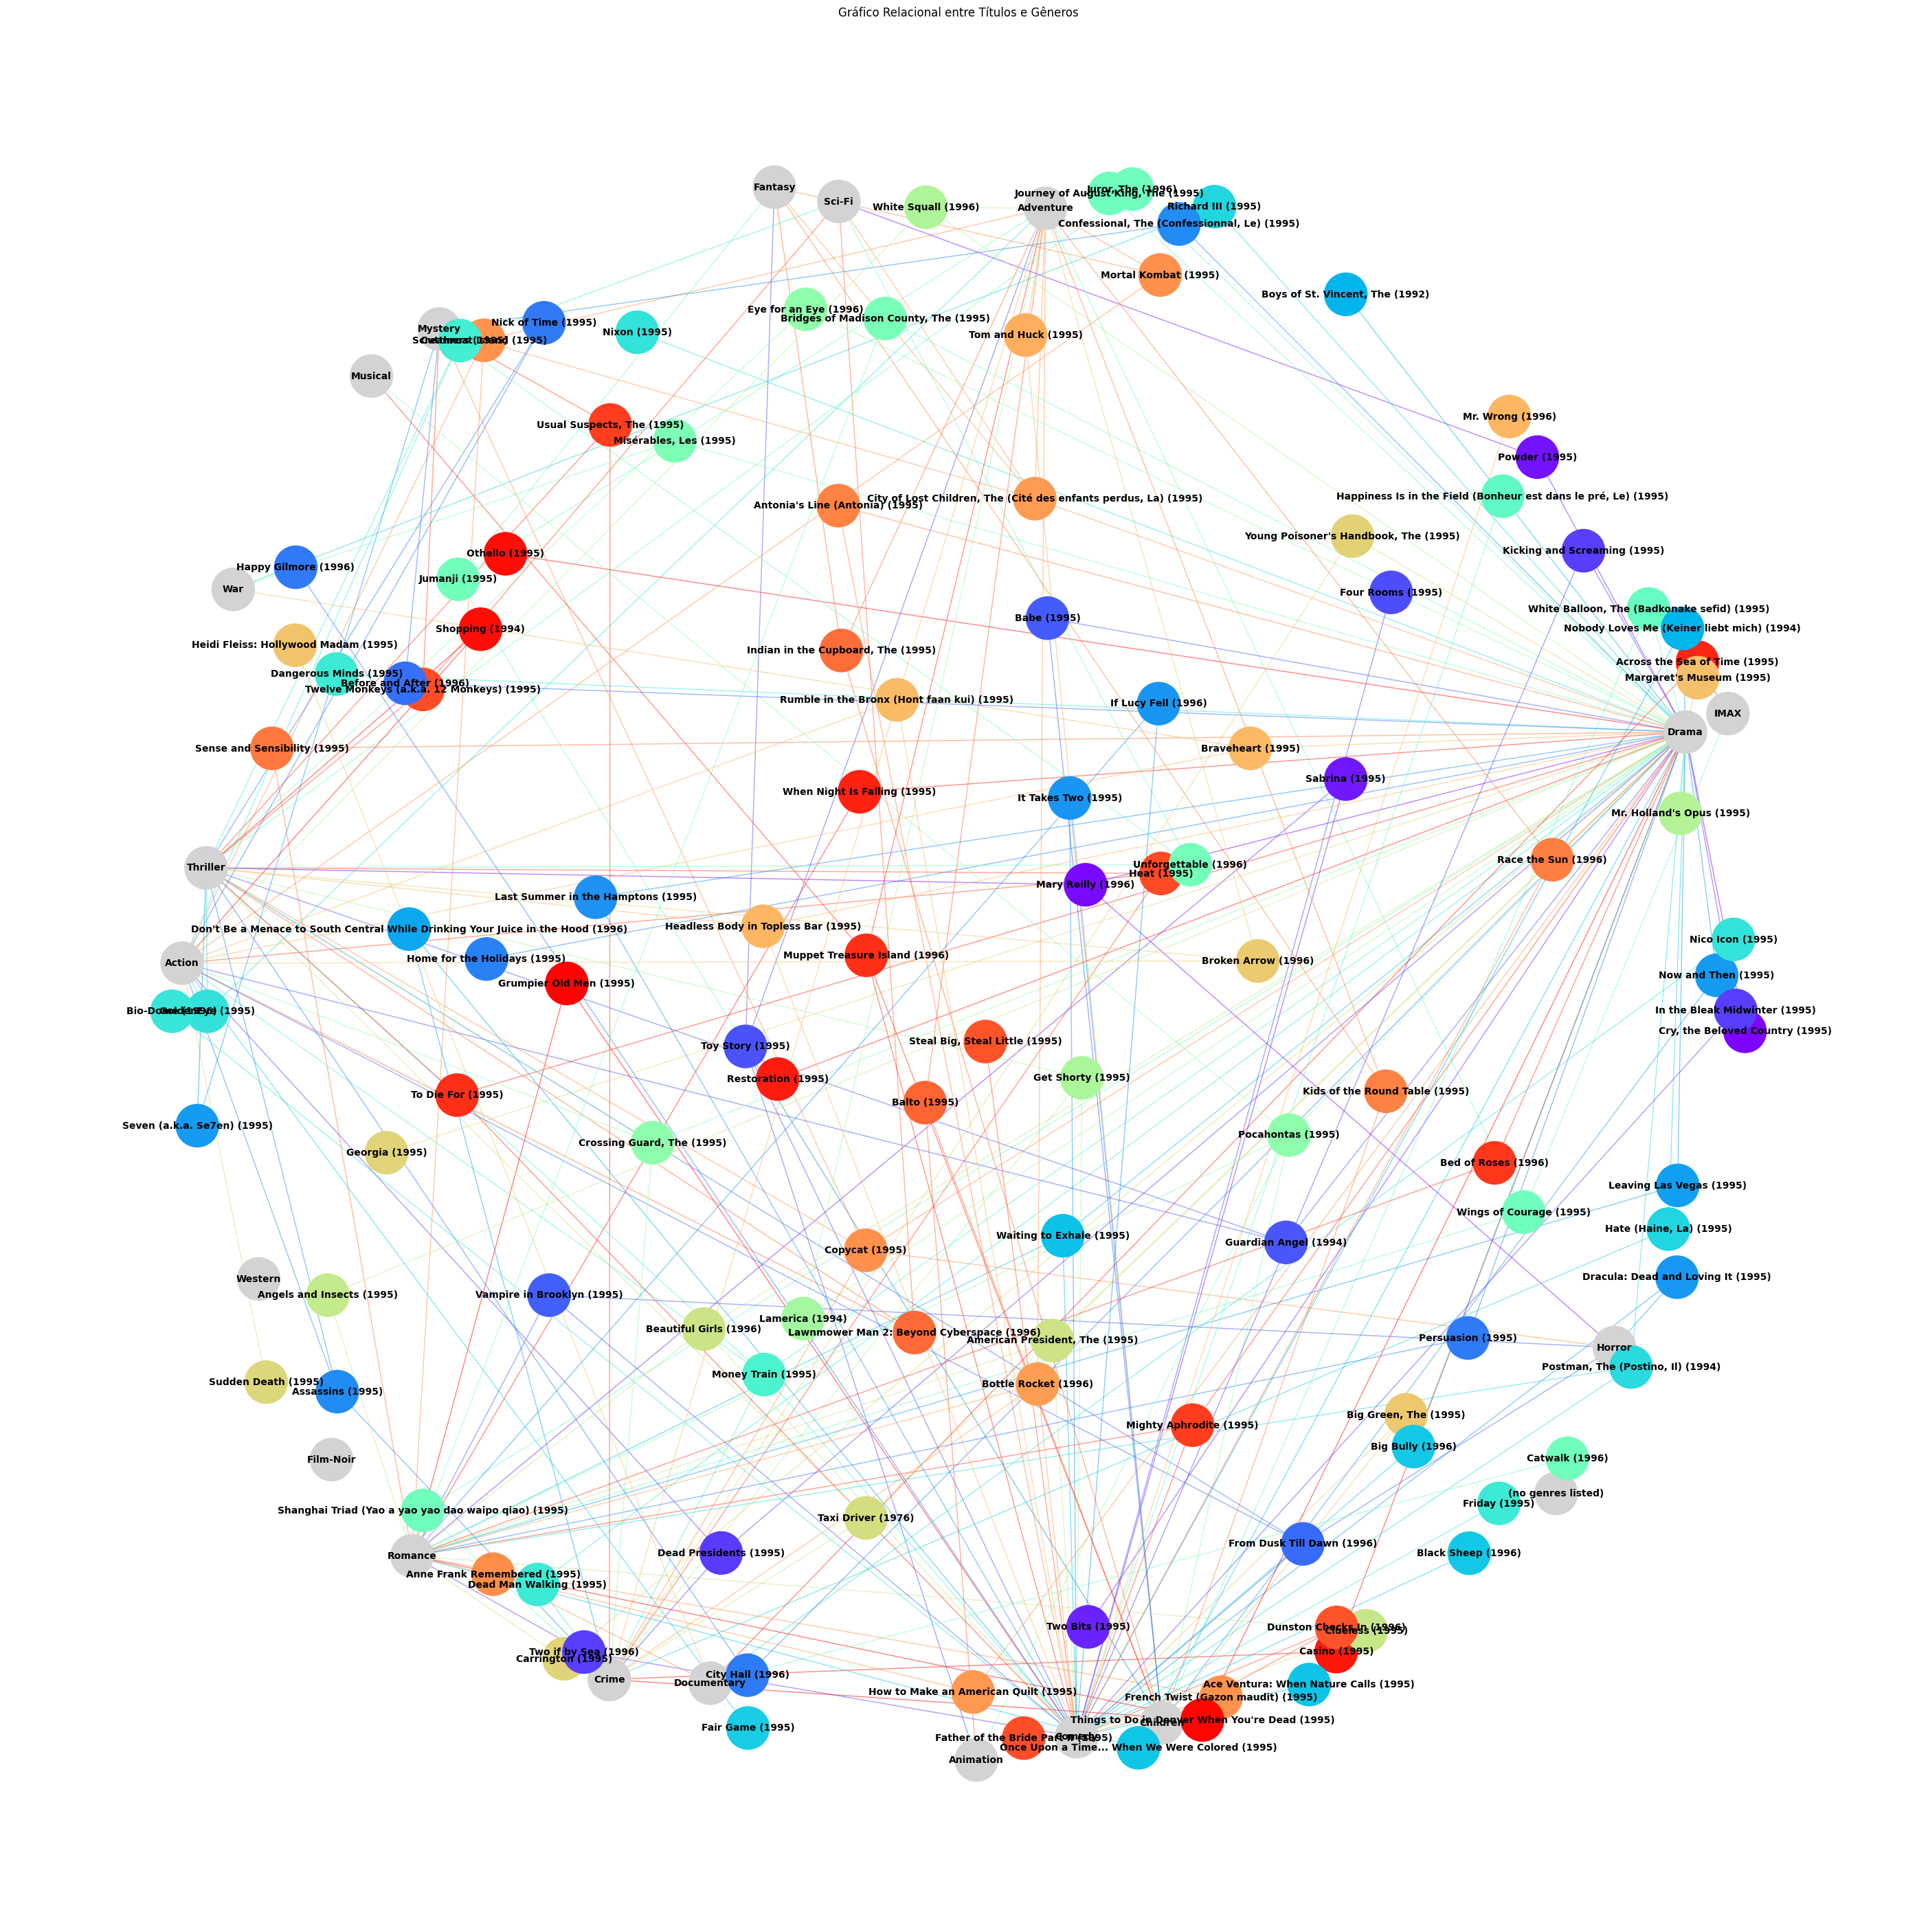

In [ ]:
pos = nx.spring_layout(G, k=1.6, iterations=100, seed=42) #Configurar o layout do gráfico, o k é para aumentar a distancia entre os nós.
plt.figure(figsize=(28, 28)) #Ajustar o tamanho da figura (aumente as dimensões se desejar uma imagem maior)
node_colors = {node: node_colors[node] if G.nodes[node]['tipo'] == 'Filme' else 'lightgray' for node in G.nodes} # Mapeie as cores dos nós dos filmes
edge_colors = [node_colors[edge[0]] for edge in G.edges] #Mapear as cores das arestas para as cores dos nós dos Filmes
nx.draw_networkx_nodes(G, pos, node_color=list(node_colors.values()), node_size=2000, alpha=1.0) # Setando as cores nos nós com as cores mapeadas
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color=edge_colors) # Setando as arestas com as cores mapeadas dos nós de origem

#Rotulando os nós
labels = {node: node for node in G.nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight='bold')

# Configurando o título e exibindo o gráfico
plt.tight_layout()
plt.title("Gráfico Relacional entre Títulos e Gêneros")
plt.axis('off')  #Desligue os eixos
plt.show()